#klasifikasi jenis burung menggunakan CNN dengan model pre train resnet50

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"herutriana","key":"af436e428852deadc1ebbc46c34612b1"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d gpiosenka/100-bird-species

 99% 1.49G/1.49G [00:47<00:00, 32.8MB/s]
100% 1.49G/1.49G [00:47<00:00, 33.9MB/s]


In [5]:
# General Libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
tf.__version__

'2.8.2'

In [6]:
import os

def walk_on_dir(dir):
    print(dir)
    i = 0 
    for path, dirs, files in os.walk(dir):
        if len(dirs) > 0:
            print(len(dirs))
            print(dirs)
            _dirs = dirs
        else:
            print(path)
            print(_dirs[i])
            print(files)
            i+=1
    print(i)

In [7]:
def plot_training_curves(history):
    # Training curves
    import matplotlib.pyplot as plt

    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']

    epochs_x = range(1, len(loss_values) + 1)
    plt.figure(figsize=(10,10))
    plt.subplot(2,1,1)
    plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
    plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation Loss and Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(2,1,2)
    acc_values = history_dict['accuracy']
    val_acc_values = history_dict['val_accuracy']
    plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
    plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
    #plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend()
    plt.show()

In [8]:
def print_metrics(model, dataset_generator):
    score = model.evaluate(test_generator)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('Test ROC AUC:', score[2])

In [9]:
import zipfile,os
zip_lcl = '/content/100-bird-species.zip'
rzip = zipfile.ZipFile(zip_lcl, 'r')
rzip.extractall('/content')
rzip.close()

In [10]:
MAX_EPOCHS = 30
PATIENCE = 4

def train_model(model_id, model, train_generator, val_generator):

    # Salva o melhor modelo
    cb_save_best_model = keras.callbacks.ModelCheckpoint(filepath=model_id,
                                                         monitor='val_loss', 
                                                         save_best_only=True, 
                                                         verbose=1)

    # Encerra o treino antecipadamente se não houver evolução
    cb_early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  patience= PATIENCE,
                                                  verbose=1)


    history = model.fit(
            train_generator,
            steps_per_epoch = train_generator.samples // BATCH_SIZE,
            epochs=MAX_EPOCHS,
            callbacks = [cb_save_best_model, cb_early_stop],
            validation_data=val_generator,
            verbose = 1,
            validation_steps= val_generator.samples // BATCH_SIZE)
    
    return history

In [11]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def plot_confusion_matrix_and_classification_report(model, dataset_generator, classes):
    Y_pred = model.predict(dataset_generator)
    y_pred = np.argmax(Y_pred, axis=1)
    
    #Confution Matrix
    cm = confusion_matrix(test_generator.classes, y_pred)
    plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix')

    #Classification Report
    print('Classification Report')
    print(classification_report(test_generator.classes, y_pred, target_names=classes))

In [13]:
IMG_SHAPE = (244,244)
INPUT_SHAPE = (IMG_SHAPE[0], IMG_SHAPE[1], 3)

TRAIN_DIR = '/content/train'
TEST_DIR = '/content/train'
VAL_DIR = '/content/valid'

BATCH_SIZE = 16

RANDOM_SEED = 33

MAX_CLASSES = 30

In [14]:
classes = os.listdir(TRAIN_DIR)
num_classes = len(classes)
num_classes

400

In [15]:
# Untuk eksperimen, mari kita pilih N kelas secara acak

import random

random.Random(RANDOM_SEED).shuffle(classes)

classes = classes[:MAX_CLASSES]
num_classes = len(classes)

classes

['EMERALD TANAGER',
 'GUINEA TURACO',
 'CASPIAN TERN',
 'ENGGANO MYNA',
 'SORA',
 'CERULEAN WARBLER',
 'MASKED LAPWING',
 'EARED PITA',
 'STRIPPED MANAKIN',
 'CRIMSON CHAT',
 'FLAME BOWERBIRD',
 'AVADAVAT',
 'PARAKETT  AKULET',
 'BAND TAILED GUAN',
 'GOLD WING WARBLER',
 'CHARA DE COLLAR',
 'KIWI',
 'DOUBLE EYED FIG PARROT',
 'WHITE NECKED RAVEN',
 'GREATOR SAGE GROUSE',
 'AFRICAN EMERALD CUCKOO',
 'POMARINE JAEGER',
 'BARRED PUFFBIRD',
 'CINNAMON ATTILA',
 'CHUCAO TAPACULO',
 'ANNAS HUMMINGBIRD',
 'COCKATOO',
 'ELLIOTS  PHEASANT',
 'ALBATROSS',
 'CAPE ROCK THRUSH']

Found 58388 images belonging to 400 classes.


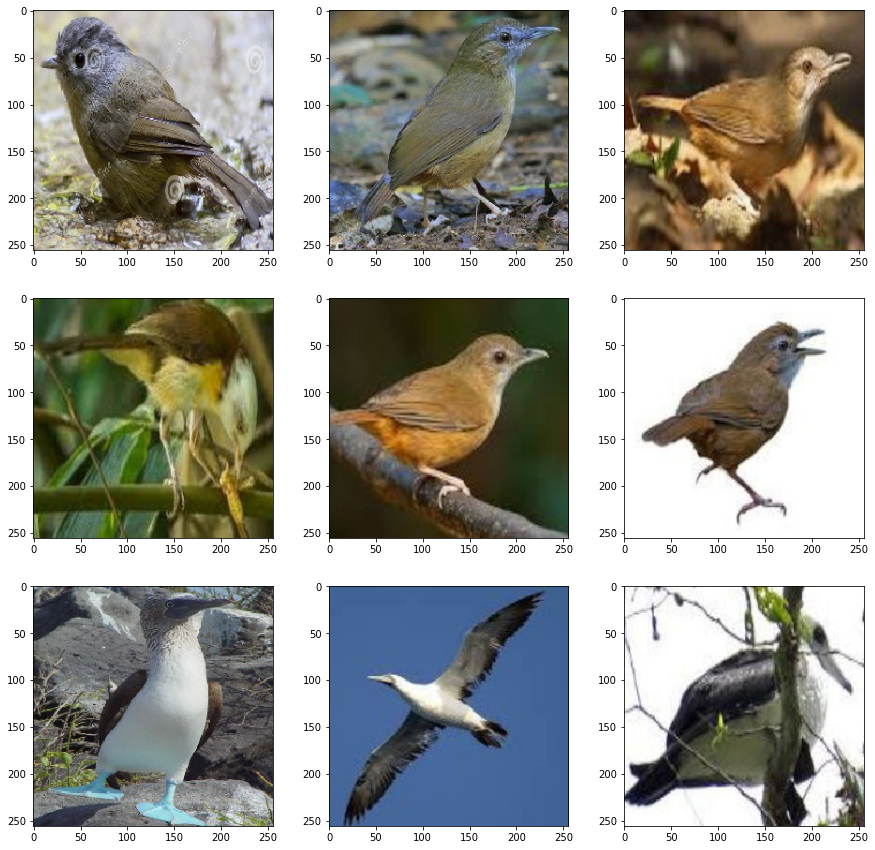

In [16]:
# Memvisualisasikan beberapa data sampel

sample_generator = ImageDataGenerator().flow_from_directory(TEST_DIR, shuffle=False)

plt.figure(figsize=(15,15))
for i in range(9):
    # 3x3 grid
    plt.subplot(330 + 1 + i)
    batch = sample_generator.next()[0]
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

# Pre-processing

In [17]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [18]:
#konfigurasi model resnet50
generator_args = {
    "preprocessing_function":preprocess_input,
}
flow_args = {
    "target_size":IMG_SHAPE,
    "seed":RANDOM_SEED,
    "batch_size":BATCH_SIZE,
    "class_mode":"categorical",
    "classes":classes,
}

In [19]:
#buat augmentasi data
img_generator = ImageDataGenerator(**generator_args)
augmented_img_generator = ImageDataGenerator(rotation_range=20,
                                             width_shift_range=0.1,
                                             height_shift_range=0.1,
                                             shear_range=0.1,
                                             zoom_range=0.1,
                                             horizontal_flip=True,
                                             fill_mode='nearest',
                                             **generator_args)

In [20]:
#menerapkan augmentasi data
train_generator = augmented_img_generator.flow_from_directory(TRAIN_DIR, shuffle=True, **flow_args)
test_generator = img_generator.flow_from_directory(TEST_DIR, shuffle=False, **flow_args)
val_generator = img_generator.flow_from_directory(VAL_DIR, shuffle=False, **flow_args)

Found 4418 images belonging to 30 classes.
Found 4418 images belonging to 30 classes.
Found 150 images belonging to 30 classes.


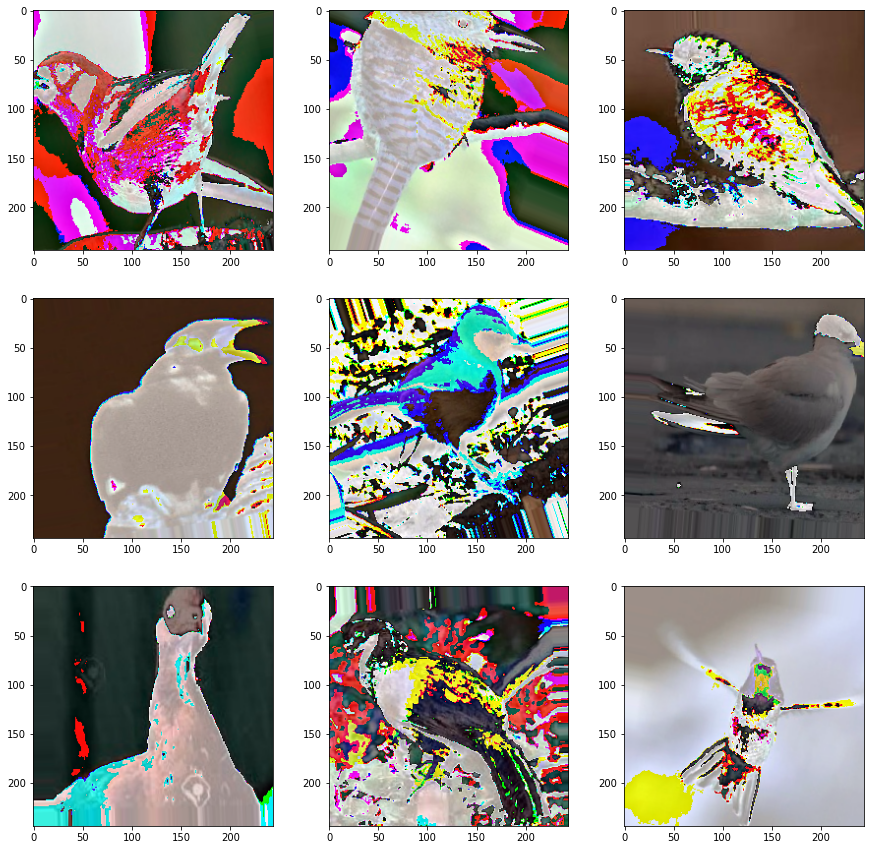

In [21]:
# Memvisualisasikan beberapa contoh yang telah diproses sebelumnya

plt.figure(figsize=(15,15))
for i in range(9):
    # 3x3 grid
    plt.subplot(330 + 1 + i)
    batch = train_generator.next()[0]
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

# Transfer learning Model Menggunakan ResNet50

In [22]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

x = base_model.output
x = Flatten()(x)
x = Dense(120, activation='sigmoid')(x)
x = Dropout(0.1)(x)

predictions = Dense(num_classes, activation='softmax', kernel_initializer='random_uniform')(x)

model = Model(inputs=base_model.input, 
              outputs=predictions)
model.summary()

# Freezing pretrained layers
for layer in base_model.layers:
    layer.trainable=False
#compile model
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy', "AUC"])

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 244, 244, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 250, 250, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 122, 122, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [23]:
MODEL_ID = 'resnet50.model.bruno.h5'
#training memakai model resnet50
history = train_model(MODEL_ID, model, train_generator, val_generator)

Epoch 1/30
276/276 [==============================] - ETA: 0s - loss: 2.9139 - accuracy: 0.2976 - auc: 0.8227
Epoch 1: val_loss improved from inf to 2.39999, saving model to resnet50.model.bruno.h5
276/276 [==============================] - 83s 246ms/step - loss: 2.9139 - accuracy: 0.2976 - auc: 0.8227 - val_loss: 2.4000 - val_accuracy: 0.5000 - val_auc: 0.9456
Epoch 2/30
276/276 [==============================] - ETA: 0s - loss: 1.9959 - accuracy: 0.6349 - auc: 0.9699
Epoch 2: val_loss improved from 2.39999 to 1.51752, saving model to resnet50.model.bruno.h5
276/276 [==============================] - 67s 242ms/step - loss: 1.9959 - accuracy: 0.6349 - auc: 0.9699 - val_loss: 1.5175 - val_accuracy: 0.8750 - val_auc: 0.9935
Epoch 3/30
276/276 [==============================] - ETA: 0s - loss: 1.3424 - accuracy: 0.8105 - auc: 0.9891
Epoch 3: val_loss improved from 1.51752 to 0.90774, saving model to resnet50.model.bruno.h5
276/276 [==============================] - 67s 241ms/step - loss: 

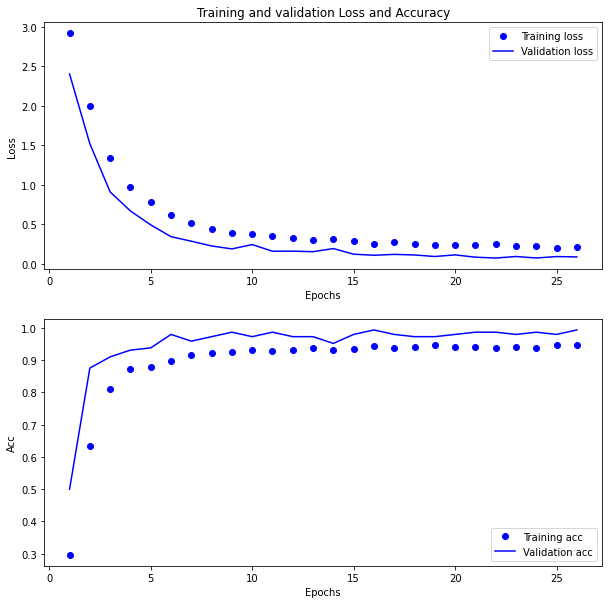

In [24]:
plot_training_curves(history)

In [25]:
#tampilkan hasil test loss, akurasi, ROC AUC
print_metrics(model, test_generator)

277/277 [==============================] - 21s 76ms/step - loss: 0.1014 - accuracy: 0.9776 - auc: 0.9995
Test loss: 0.1014133095741272
Test accuracy: 0.9775916934013367
Test ROC AUC: 0.9995456337928772


Classification Report
                        precision    recall  f1-score   support

       EMERALD TANAGER       0.98      0.99      0.98       139
         GUINEA TURACO       0.97      0.99      0.98       162
          CASPIAN TERN       0.99      1.00      1.00       213
          ENGGANO MYNA       0.98      0.97      0.98       124
                  SORA       0.97      0.96      0.97       200
      CERULEAN WARBLER       0.98      0.97      0.98       163
        MASKED LAPWING       0.99      0.98      0.98       131
            EARED PITA       0.98      0.97      0.98       125
      STRIPPED MANAKIN       1.00      0.97      0.99       144
          CRIMSON CHAT       0.99      0.98      0.99       154
       FLAME BOWERBIRD       0.98      0.92      0.95       121
              AVADAVAT       0.98      0.98      0.98       164
      PARAKETT  AKULET       0.99      0.97      0.98       130
      BAND TAILED GUAN       0.97      0.93      0.95       123
     GOLD WING WA

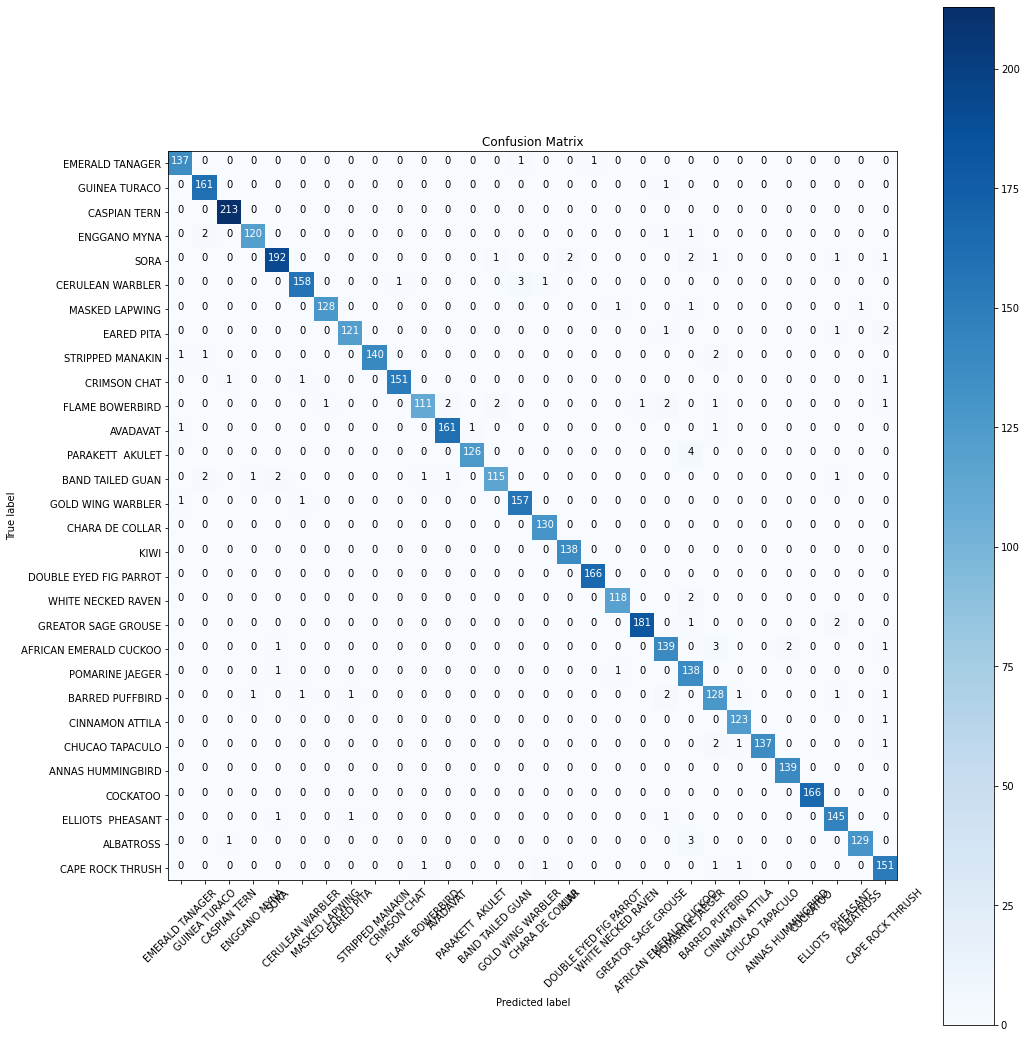

In [26]:
#tampilkan confusion matrix dan hasil klasifikasi model
plot_confusion_matrix_and_classification_report(model, test_generator, classes)

In [27]:
list_class = list(os.listdir('/content/test'))
list_class.sort()
list_class

['ABBOTTS BABBLER',
 'ABBOTTS BOOBY',
 'ABYSSINIAN GROUND HORNBILL',
 'AFRICAN CROWNED CRANE',
 'AFRICAN EMERALD CUCKOO',
 'AFRICAN FIREFINCH',
 'AFRICAN OYSTER CATCHER',
 'ALBATROSS',
 'ALBERTS TOWHEE',
 'ALEXANDRINE PARAKEET',
 'ALPINE CHOUGH',
 'ALTAMIRA YELLOWTHROAT',
 'AMERICAN AVOCET',
 'AMERICAN BITTERN',
 'AMERICAN COOT',
 'AMERICAN GOLDFINCH',
 'AMERICAN KESTREL',
 'AMERICAN PIPIT',
 'AMERICAN REDSTART',
 'AMETHYST WOODSTAR',
 'ANDEAN GOOSE',
 'ANDEAN LAPWING',
 'ANDEAN SISKIN',
 'ANHINGA',
 'ANIANIAU',
 'ANNAS HUMMINGBIRD',
 'ANTBIRD',
 'ANTILLEAN EUPHONIA',
 'APAPANE',
 'APOSTLEBIRD',
 'ARARIPE MANAKIN',
 'ASHY THRUSHBIRD',
 'ASIAN CRESTED IBIS',
 'AVADAVAT',
 'AZURE JAY',
 'AZURE TANAGER',
 'AZURE TIT',
 'BAIKAL TEAL',
 'BALD EAGLE',
 'BALD IBIS',
 'BALI STARLING',
 'BALTIMORE ORIOLE',
 'BANANAQUIT',
 'BAND TAILED GUAN',
 'BANDED BROADBILL',
 'BANDED PITA',
 'BANDED STILT',
 'BAR-TAILED GODWIT',
 'BARN OWL',
 'BARN SWALLOW',
 'BARRED PUFFBIRD',
 'BARROWS GOLDENEYE',
 'BAY-B

In [28]:
list_class[1]

'ABBOTTS BOOBY'

Saving 1.jpg to 1 (1).jpg
8


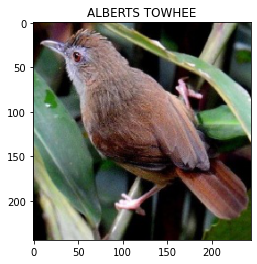

In [33]:
labels = train_generator.classes
label_to_text = {i:label for i,label in enumerate(classes)}
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():
 
    # predicting images
    path = fn
    img = image.load_img(path, target_size=IMG_SHAPE)
    imgplot = plt.imshow(img)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=BATCH_SIZE)

    # find the index of the class with the highest probability
    class_index = np.argmax(classes)
    # plot the image and the class
    print(class_index)
    class_indeks = int(class_index)
    pred = list_class[class_indeks]
    plt.imshow(img)
    plt.title(pred)
    plt.show()
    